## PyRCA: simulation

In [11]:
%reload_ext autoreload
%autoreload 2


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True


In [3]:
import sys
sys.path.append('../')


In [5]:
from PyRCA.pyrca.simulation import data_gen


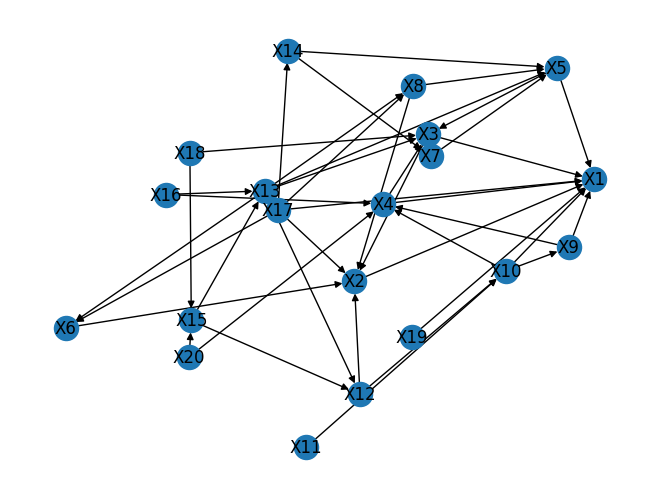

In [6]:
import networkx as nx

graph_matrix = data_gen.DAGGen(data_gen.DAGGenConfig(num_node=20, num_edge=40)).gen()
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

nx.draw(G, with_labels = True)


In [7]:
config = data_gen.DataGenConfig(dag=graph_matrix, func_type='identity', noise_type='laplace', weight_generator='normal', num_samples=160)
normal_data, parent_weights, noise_weights, func_form, noise_form = data_gen.DataGen(config).gen()


In [8]:
normal_data


array([[-2.78306410e+01, -2.52900937e+00, -8.70106409e+00, ...,
        -3.49089736e-01,  9.60017589e-01,  3.31211071e-03],
       [ 7.57653916e+00,  6.05578001e+00,  5.39805909e+00, ...,
        -2.08402672e-01, -4.64977833e-01,  1.01973386e+00],
       [-4.77411339e+01, -7.01521654e+00, -7.25070619e+00, ...,
         4.96463388e-01,  2.52200615e+00,  4.43969774e-01],
       ...,
       [-1.16987341e+01, -1.17843870e+01, -9.41341031e+00, ...,
        -3.32969207e-02, -1.99112292e+00,  6.87453889e-01],
       [-2.50836758e+01, -5.75931639e+00, -1.00377313e+01, ...,
         6.11317126e-01,  4.29679082e-02,  3.56615627e+00],
       [-2.21772085e+01, -7.68892878e+00, -1.01628462e+01, ...,
        -1.02197481e+00,  8.30587983e-01,  4.60514814e+00]])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

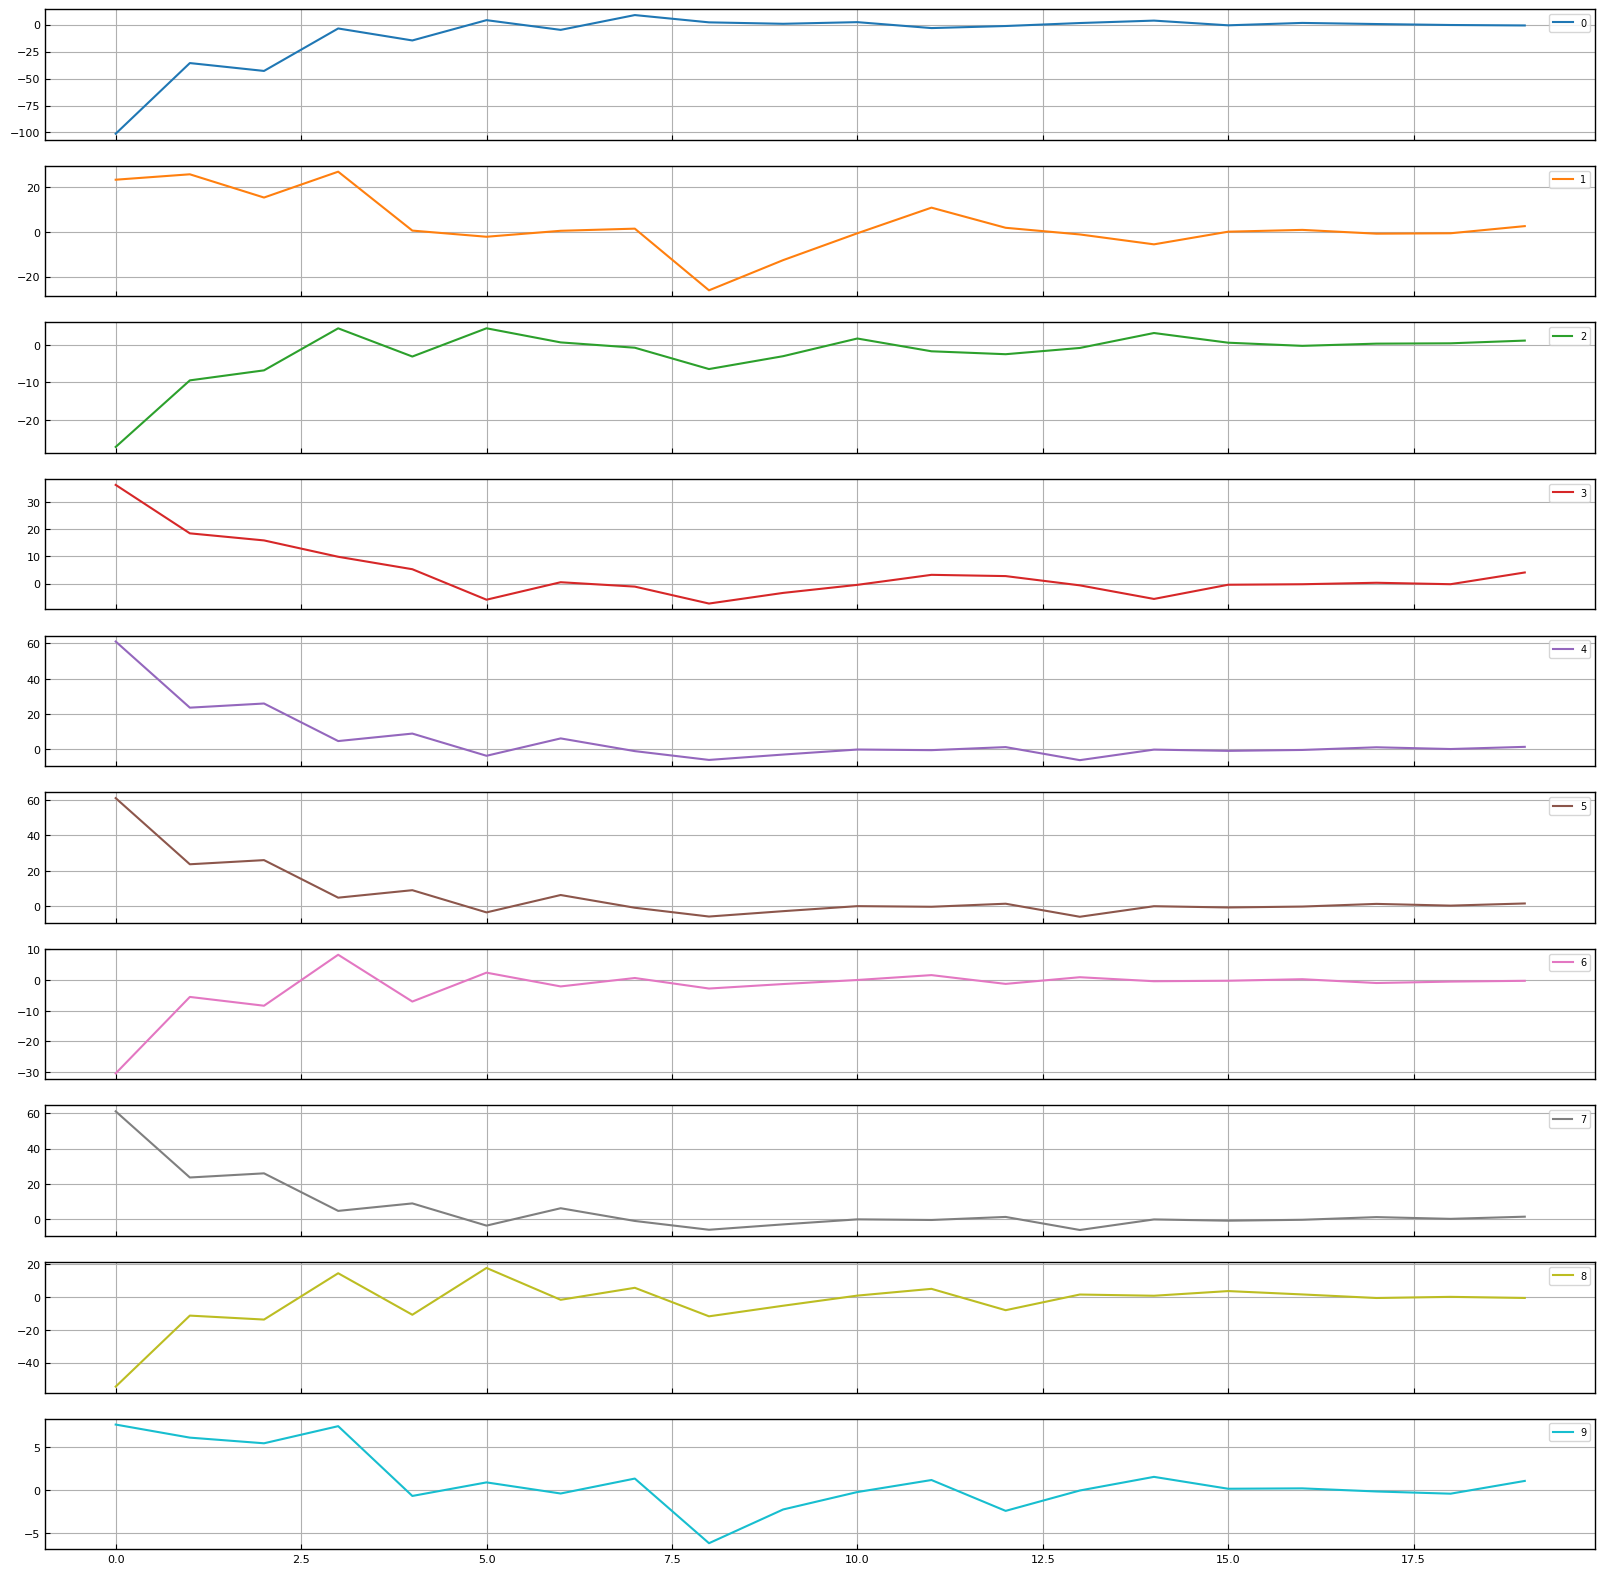

In [9]:
pd.DataFrame(normal_data[np.random.choice(normal_data.shape[1], size=10)].T).plot(subplots=True, figsize=(20, 20))


In [ ]:
_SLI = 0
tau = 3
baseline = normal_data[:, _SLI].mean()
sli_sigma = normal_data[:, _SLI].std()
threshold = tau * sli_sigma


In [ ]:
config = data_gen.AnomalyDataGenConfig(
    parent_weights=parent_weights,
    noise_weights=noise_weights,
    func_type=func_form,
    noise_type=noise_form,
    threshold=threshold,
    baseline=baseline,
    anomaly_type=1,
    num_samples=20,
)
anomaly_data, fault = data_gen.AnomalyDataGen(config).gen()


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

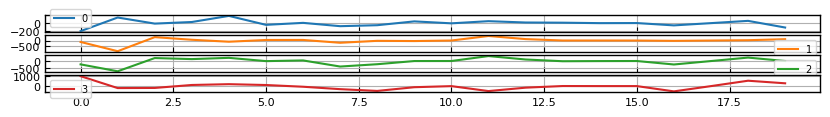

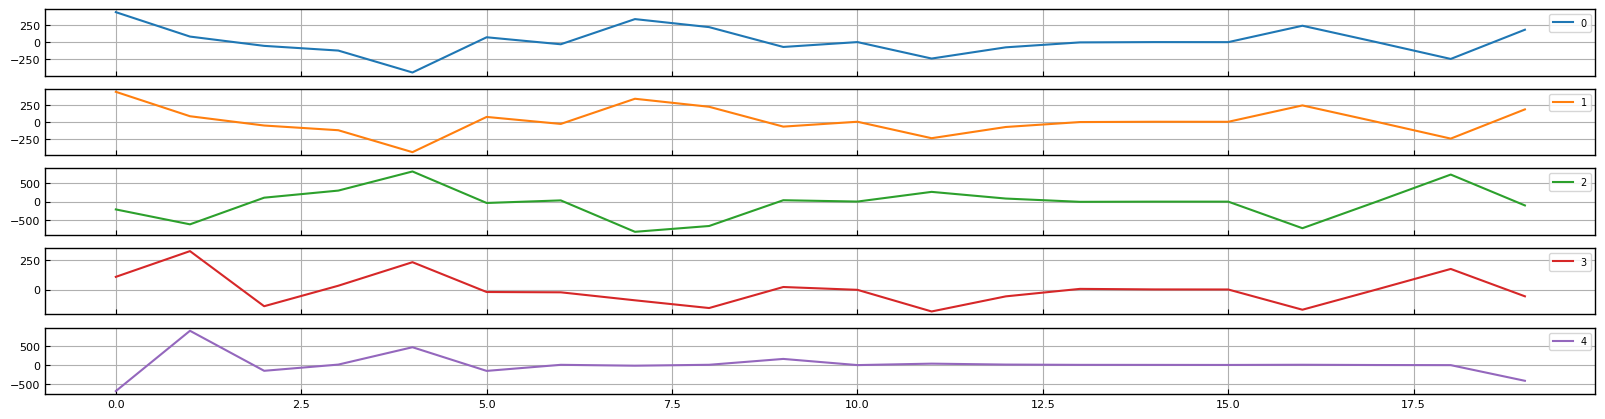

In [ ]:
pd.DataFrame(anomaly_data[np.where(fault != 0)[0]].T).plot(subplots=True, figsize=(10, 1))
pd.DataFrame(anomaly_data[np.random.choice(anomaly_data.shape[1], size=5)].T).plot(subplots=True, figsize=(20, 5))


The generated graph: True is directed and acyclic.


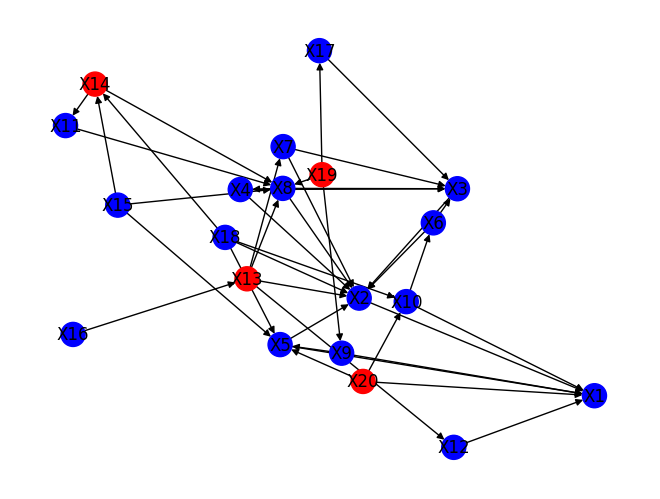

In [ ]:
# constructure networkx graph from adjacent matrix
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

# label the root cause nodes
no_of_var = graph_matrix.shape[0]
color_list = np.array(['blue','red'])
node_color_idx = np.zeros(no_of_var).astype(int)
node_color_idx[fault != 0] = 1
node_color = color_list[node_color_idx]
print(f"The generated graph: {nx.is_directed_acyclic_graph(G)} is directed and acyclic.")
nx.draw(G, with_labels = True, node_color=node_color)


In [3]:
import sys
sys.path.append('../PyRCA')


In [9]:
from pyrca.graphs.causal.pc import PC
import pandas as pd

# load data
normal_data_df = pd.DataFrame(normal_data, columns=node_names)
abnormal_data_df = pd.DataFrame(anomaly_data, columns=node_names)


NameError: name 'normal_data' is not defined

In [ ]:
from pyrca.analyzers.ht import HT, HTConfig

# train causal graph construction model
model = PC(PC.config_class())
estimated_matrix = model.train(normal_data_df)
model = HT(config=HTConfig(graph=estimated_matrix, root_cause_top_k=10))
model.train(normal_data_df)

results = model.find_root_causes(abnormal_data_df, "X1", adjustment=True).to_list()
print(results)


  0%|          | 0/20 [00:00<?, ?it/s]

[{'root_cause': 'X19', 'score': 1247.3157560820612, 'paths': None}, {'root_cause': 'X10', 'score': 977.2815238412413, 'paths': None}, {'root_cause': 'X8', 'score': 949.741762706245, 'paths': None}, {'root_cause': 'X6', 'score': 827.7977240683894, 'paths': None}, {'root_cause': 'X3', 'score': 824.7300859088234, 'paths': None}, {'root_cause': 'X2', 'score': 760.0072247949498, 'paths': None}, {'root_cause': 'X13', 'score': 544.3334174188258, 'paths': None}, {'root_cause': 'X20', 'score': 390.06600149780604, 'paths': None}, {'root_cause': 'X4', 'score': 245.52072121527556, 'paths': None}, {'root_cause': 'X16', 'score': 209.72241999990985, 'paths': None}]


In [ ]:
true_root_causes = [mapping[i] for i in np.where(fault != 0)[0]]
# evaluate the results for true_root_causes
for top_k, item in enumerate(results, start=1):
    if item["root_cause"] in true_root_causes:
        print(f"Top {top_k} root cause: {item['root_cause']} is correct.")


Top 1 root cause: X19 is correct.
Top 7 root cause: X13 is correct.
Top 8 root cause: X20 is correct.


In [ ]:
from pyrca.analyzers.rcd import RCD, RCDConfig

model = RCD(config=RCDConfig(k=10, localized=True))
results = model.find_root_causes(normal_data_df, abnormal_data_df).to_list()
print(results)


[{'root_cause': 'X2', 'score': None, 'paths': None}, {'root_cause': 'X9', 'score': None, 'paths': None}, {'root_cause': 'X20', 'score': None, 'paths': None}, {'root_cause': 'X3', 'score': None, 'paths': None}, {'root_cause': 'X13', 'score': None, 'paths': None}, {'root_cause': 'X5', 'score': None, 'paths': None}, {'root_cause': 'X6', 'score': None, 'paths': None}]


In [ ]:
# evaluate the results for true_root_causes
for top_k, item in enumerate(results, start=1):
    if item["root_cause"] in true_root_causes:
        print(f"Top {top_k} root cause: {item['root_cause']} is correct.")


Top 3 root cause: X20 is correct.
Top 5 root cause: X13 is correct.


## Massive Experiments

In [10]:
import sys
sys.path.append('../PyRCA')


In [6]:
num_trials = 5
anomaly_types = [0, 1]
func_types = ["identity"]#"square", "sin", "tanh"]
noise_types = ["normal", "exponential", "uniform", "laplace"]
weight_generators = ["normal", "uniform"]
# _VALID_FUNC = ["identity", "square", "sin", "tanh"]
# _VALID_NOISE = ["normal", "exponential", "uniform", "laplace"]
# _VALID_WEIGHT = ["normal", "uniform"]
data_scale_params = [
    {"num_node": 50, "num_edge": 100, "num_normal_samples": 160, "num_abnormal_samples": 20},
    {"num_node": 50, "num_edge": 200, "num_normal_samples": 160, "num_abnormal_samples": 20},
    {"num_node": 100, "num_edge": 500, "num_normal_samples": 160, "num_abnormal_samples": 20},
    {"num_node": 100, "num_edge": 750, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 500, "num_edge": 5000, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 480, "num_abnormal_samples": 60},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 60, "num_abnormal_samples": 60},
    # {"num_node": 100, "num_edge": 500, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 100, "num_edge": 500, "num_normal_samples": 480, "num_abnormal_samples": 60},
    # {"num_node": 200, "num_edge": 1000, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 500, "num_edge": 5000, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 200, "num_edge": 1000, "num_normal_samples": 480, "num_abnormal_samples": 60},
    # {"num_node": 1200, "num_edge": 6000, "num_normal_samples": 160, "num_abnormal_samples": 80},
    # {"num_node": 300, "num_edge": 600, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 20, "num_abnormal_samples": 20},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 60, "num_abnormal_samples": 60},
    # {"num_node": 1200, "num_edge": 6000, "num_normal_samples": 60, "num_abnormal_samples": 60},
]

# dataset = generate_datasets_from_param_sets(anomaly_types, data_scale_params, func_types, noise_types, weight_generators, num_trials)


### Feature Reduction Evaluation

In [21]:
fl_results = sum([
    sweep_load_and_reduction(anomaly_types, data_scale_params, func_types, noise_types, weight_generators, [trial_no], n_jobs=-1) for trial_no in range(1, num_trials+1)
], [])


Running anomaly type 0 with data scale {'num_node': 50, 'num_edge': 100, 'num_normal_samples': 160, 'num_abnormal_samples': 20}, func_type: identity, noise_type: normal, weight_generator:normal, trian_no 1...
Running anomaly type 0 with data scale {'num_node': 50, 'num_edge': 100, 'num_normal_samples': 160, 'num_abnormal_samples': 20}, func_type: identity, noise_type: exponential, weight_generator:normal, trian_no 1...
Running anomaly type 0 with data scale {'num_node': 50, 'num_edge': 100, 'num_normal_samples': 160, 'num_abnormal_samples': 20}, func_type: identity, noise_type: laplace, weight_generator:uniform, trian_no 1...
Running anomaly type 0 with data scale {'num_node': 50, 'num_edge': 200, 'num_normal_samples': 160, 'num_abnormal_samples': 20}, func_type: identity, noise_type: uniform, weight_generator:normal, trian_no 1...
Running anomaly type 0 with data scale {'num_node': 50, 'num_edge': 200, 'num_normal_samples': 160, 'num_abnormal_samples': 20}, func_type: identity, noise_

In [23]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    fl_df = pd.DataFrame(fl_results).groupby(["anomaly_type", "num_node", "num_edge", "func_type", "noise_type", "weight_generator", "num_normal_samples", "num_abnormal_samples", "reduction_method"], as_index=True).mean().sort_index()
    display(fl_df)
    fl_df.reset_index().to_csv("materials/pyrca_feature_reduction_simulation_results.csv")


num_remained  \
anomaly_type num_node num_edge func_type noise_type  weight_generator num_normal_samples num_abnormal_samples reduction_method                 
0            50       100      identity  exponential normal           160                20                   BIRCH                     33.8   
                                                                                                              FluxInfer-AD              30.6   
                                                                                                              HDBS-R                     6.8   
                                                                                                              HDBS-SBD                   6.2   
                                                                                                              K-S test                  16.2   
                                                                                                              MetricSifter              15.6   
                                                                                                              NSigma                    37.0   
                                                                                                              None                      50.0   
                                                     uniform          160                20                   BIRCH                     30.2   
                                                                                                              FluxInfer-AD              26.4   
                                                                                                              HDBS-R                     7.4   
                                                                                                              HDBS-SBD                   5.0   
                                                                                                              K-S test                  11.2   
                                                                                                              MetricSifter              11.0   
                                                                                                              NSigma                    35.6   
                                                                                                              None                      50.0   
                                         laplace     normal           160                20                   BIRCH                     36.0   
                                                                                                              FluxInfer-AD              30.2   
                                                                                                              HDBS-R                     6.6   
                                                                                                              HDBS-SBD                   6.4   
                                                                                                              K-S test                  18.0   
                                                                                                              MetricSifter              16.0   
                                                                                                              NSigma                    37.2   
                                                                                                              None                      50.0   
                                                     uniform          160                20                   BIRCH                     38.8   
                                                                                                              FluxInfer-AD              31.8   
                                                                                                

In [16]:
fl_raw_df = pd.read_csv("materials/pyrca_feature_reduction_simulation_results.csv")
fl_df = fl_raw_df.groupby(["anomaly_type", "num_node", "num_edge", "func_type", "noise_type", "weight_generator", "num_normal_samples", "num_abnormal_samples", "reduction_method"], as_index=True).mean().sort_index()


In [20]:
fl_raw_df[fl_raw_df["reduction_method"] == "MetricSifter"]["bacc"].mean()


0.9579815674697747

In [24]:
import seaborn as sns


In [50]:
def wrap(label):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-PEARSON":
            return "HDBS-R"
    return label

def map_dataset(row: pd.Series):
    match row["num_node"], row["num_edge"]:
        case (50, 100):
            return '$\\mathcal{D}_{Sim}^{50\\,100}$'
        case (50, 200):
            return '$\\mathcal{D}_{Sim}^{50\\,200}$'
        case (100, 500):
            return '$\\mathcal{D}_{Sim}^{100\\,500}$'
        case (100, 750):
            return '$\\mathcal{D}_{Sim}^{100\\,750}$'
        case _:
            assert False, f"Unknown dataset {row['num_node']} {row['num_edge']}"

def plot_perf_of_reduction(
    df: pd.DataFrame,
    hue: str, evaluation_metric: str,
    legend_title: str,
    ylabel_title: str,
    num_of_hue: int,
    anomaly_types: list[int] = [0, 1, 2],
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    box_df = df.reset_index()
    box_df = box_df[box_df["anomaly_type"].isin(anomaly_types)]
    box_df["node/edge"] = box_df["num_node"].astype(str) + "/" + box_df["num_edge"].astype(str)
    box_df["dataset"] = box_df.apply(lambda x: map_dataset(x), axis=1)
    sns.boxplot(
        data=box_df, x="reduction_method", y=evaluation_metric, hue=hue, showfliers=False,
        order=["NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBS-SBD", "HDBS-R", "MetricSifter"],
        ax=ax,
    )

    ax.set_xlabel("Reduction Method", fontsize=12)
    ax.set_ylabel(ylabel_title, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.legend(title=legend_title)
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=num_of_hue, title=legend_title, frameon=False, fontsize=10, title_fontsize=12
    )
    fig.savefig(
        f"materials/pyrca_feature_reduction_simulation_{evaluation_metric}_by_{hue}_anomaly-{'-'.join([str(i) for i in anomaly_types])}.pdf",
        format="pdf", bbox_inches="tight",
    )


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

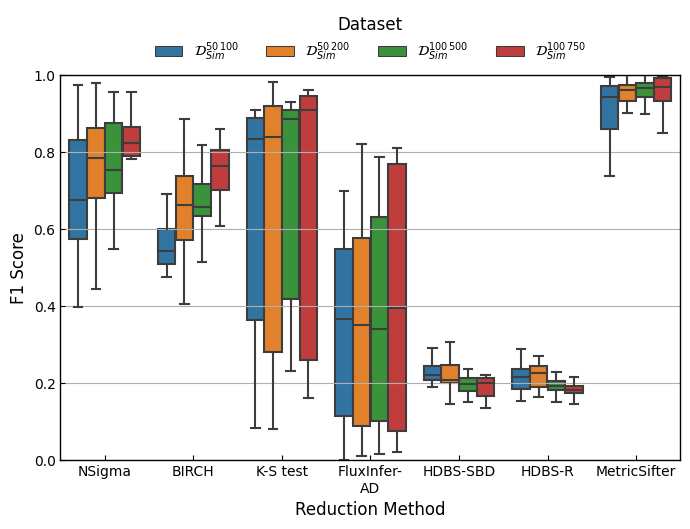

In [30]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="f1_score",
    legend_title="Dataset",
    ylabel_title="F1 Score",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

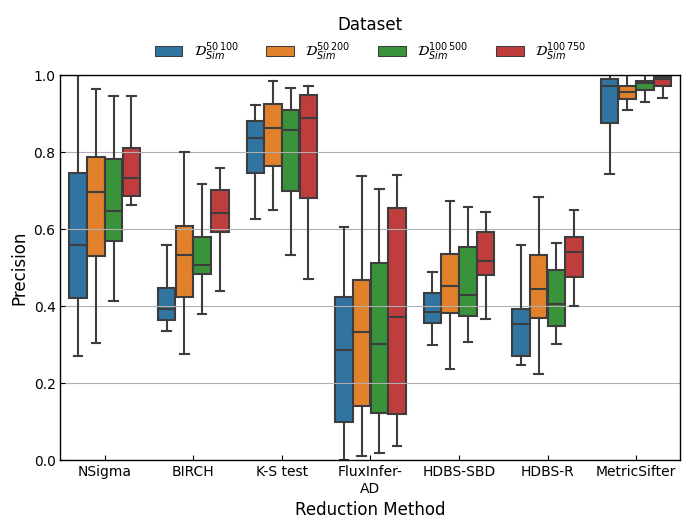

In [31]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="precision",
    legend_title="Dataset",
    ylabel_title="Precision",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

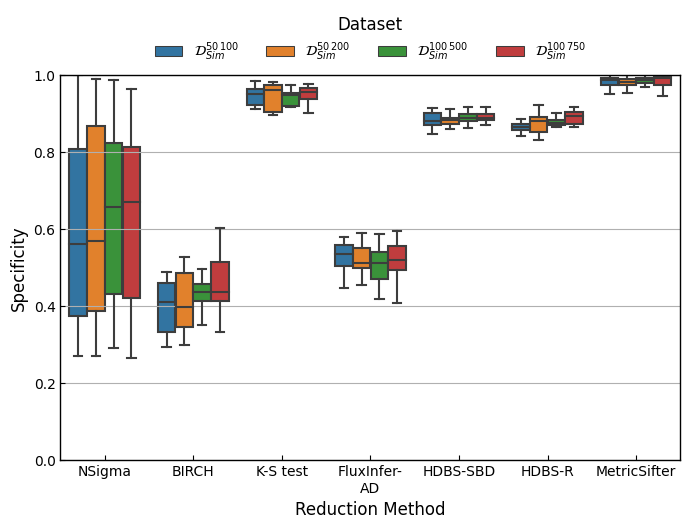

In [32]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="specificity",
    legend_title="Dataset",
    ylabel_title="Specificity",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

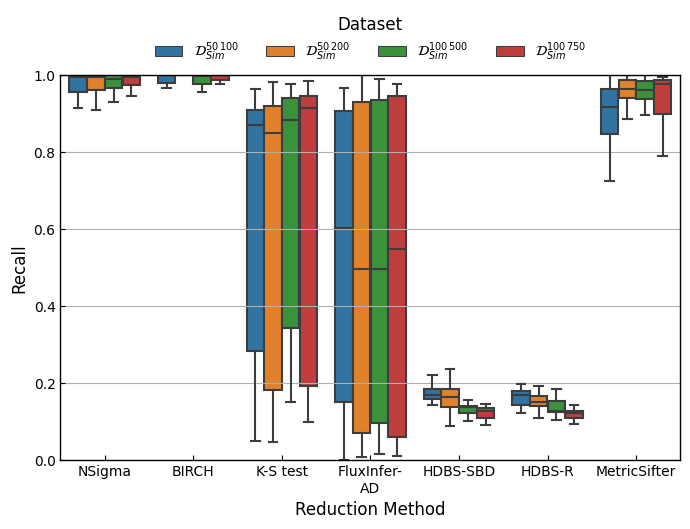

In [33]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="recall",
    legend_title="Dataset",
    ylabel_title="Recall",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

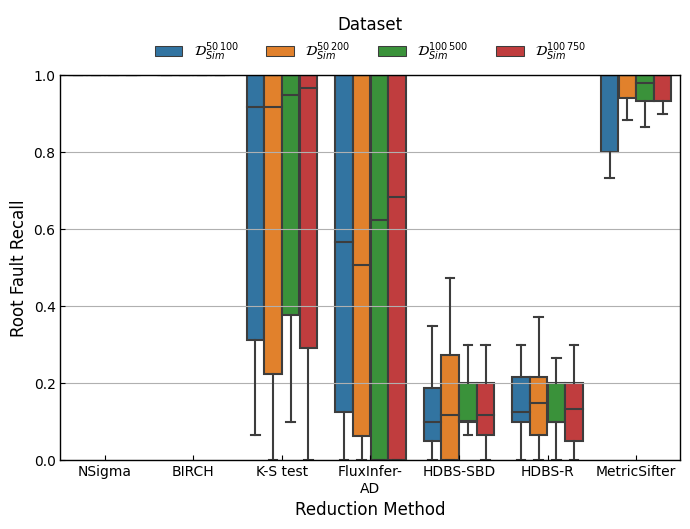

In [34]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="root_cause_recall",
    legend_title="Dataset",
    ylabel_title="Root Fault Recall",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol D from STIXNonUnicode
INFO:matplot

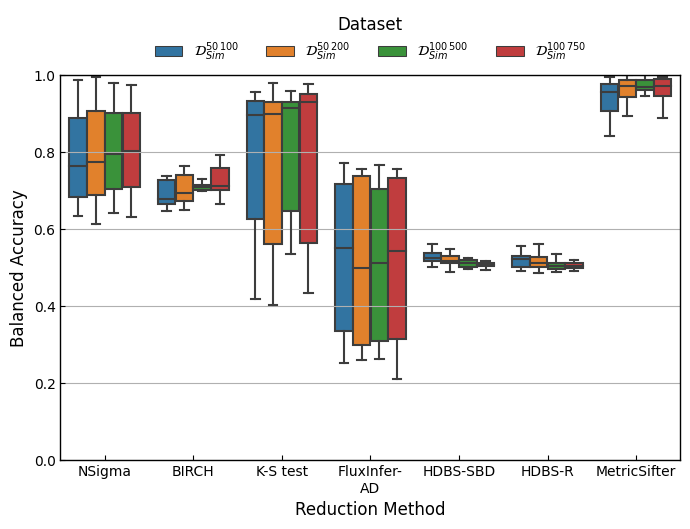

In [35]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="dataset",
    evaluation_metric="bacc",
    legend_title="Dataset",
    ylabel_title="Balanced Accuracy",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


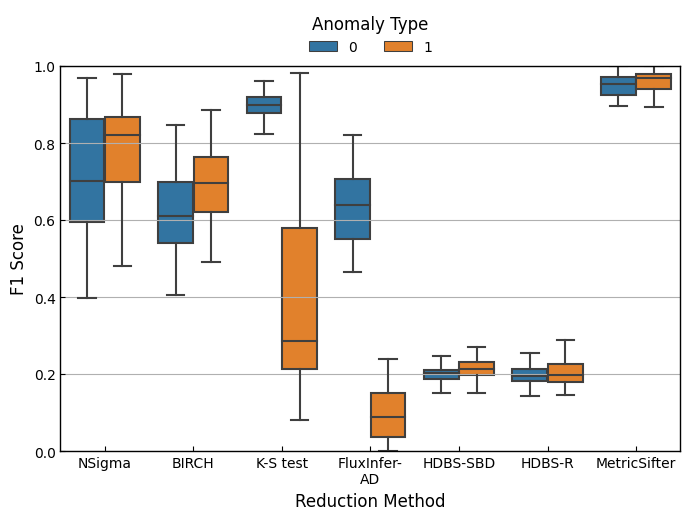

In [36]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="anomaly_type",
    evaluation_metric="f1_score",
    legend_title="Anomaly Type",
    ylabel_title="F1 Score",
    num_of_hue=3,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


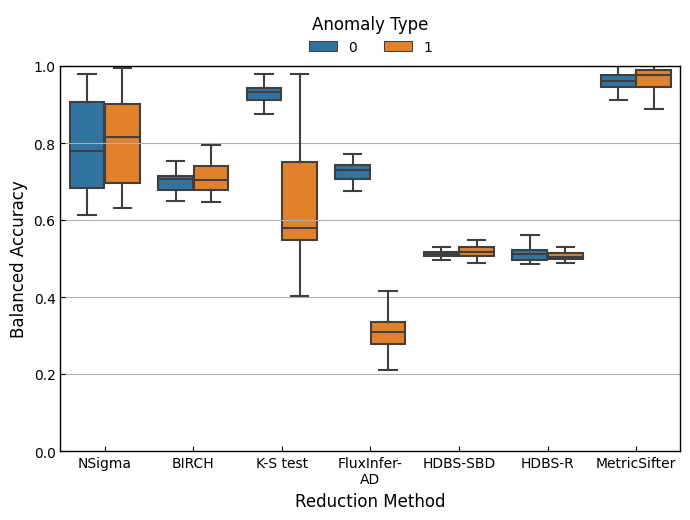

In [37]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="anomaly_type",
    evaluation_metric="bacc",
    legend_title="Anomaly Type",
    ylabel_title="Balanced Accuracy",
    num_of_hue=3,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


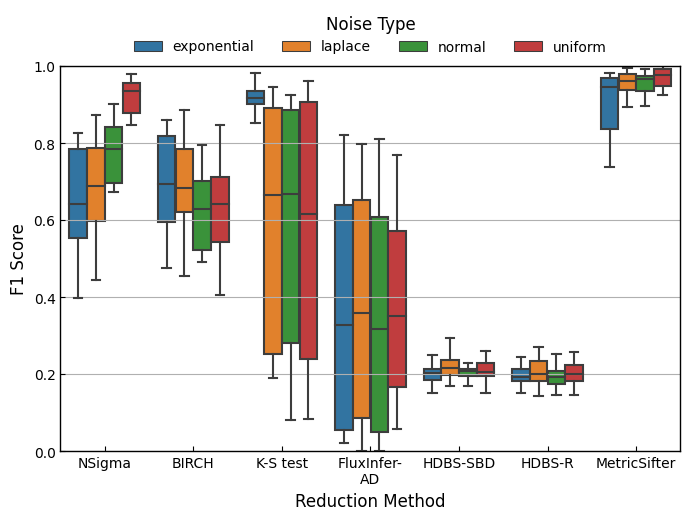

In [38]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="noise_type",
    evaluation_metric="f1_score",
    legend_title="Noise Type",
    ylabel_title="F1 Score",
    num_of_hue=4,
)


/tmp/ipykernel_1714629/2077959414.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)


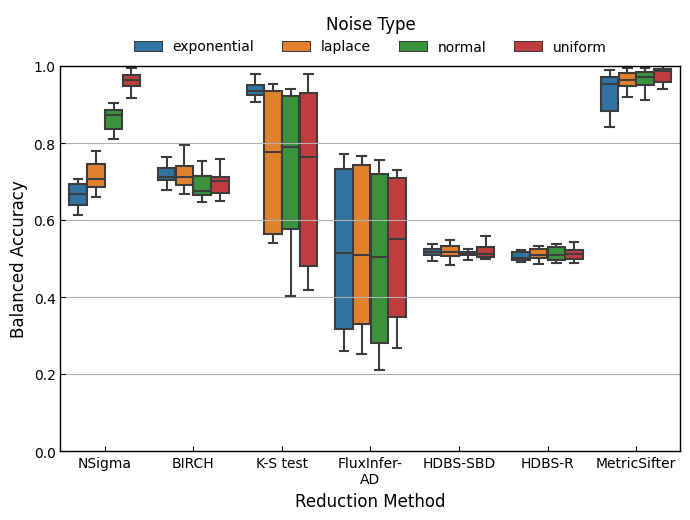

In [39]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="noise_type",
    evaluation_metric="bacc",
    legend_title="Noise Type",
    ylabel_title="Balanced Accuracy",
    num_of_hue=4,
)


In [17]:
plot_perf_of_reduction(
    fl_df.reset_index(),
    hue="weight_generator",
    evaluation_metric="bacc",
    legend_title="Weight Generator",
    ylabel_title="Balanced Accuracy",
    num_of_hue=2,
)


NameError: name 'plot_perf_of_reduction' is not defined

### RCA evaluation

In [4]:
import sys
sys.path.append('../PyRCA')


In [80]:
import pathlib

localization_dfs = []
for i in range(1, num_trials + 1):
    localization_df = pd.read_pickle(f"./materials/pyrca_feature_reduction_simulation_localization_results_{i}.pkl.gz", compression="gzip")
    localization_df.drop(localization_df[localization_df["localization_method"] == "RCD"].index, inplace=True)
    localization_dfs.append(localization_df)

for i in range(1, num_trials + 1):
    localization_df = pd.read_pickle(f"./materials/pyrca_feature_reduction_simulation_localization_results_{i}_rcd.pkl.gz", compression="gzip")
    localization_dfs.append(localization_df)

localization_df = pd.concat(localization_dfs)
localization_df["elapsed_time_sum"] = localization_df["elapsed_time_tsdr"] + localization_df["elapsed_time_loc"]
localization_df


,trial_no,k,metric,score,hit,num_root_causes,localization_method,elapsed_time_loc,num_node,num_edge,...,num_total,reduction_rate,root_cause_recall,recall,precision,specificity,f1_score,bacc,elapsed_time_tsdr,elapsed_time_sum
3,1,1,X37,78.295933,True,2,LiNGAM+HT,0.717052,50,100,...,50,0.7,0.5,0.9375,1.00,1.0,0.967742,0.96875,16.011935,16.728987
4,1,2,X7,40.081374,False,2,LiNGAM+HT,0.717052,50,100,...,50,0.7,0.5,0.9375,1.00,1.0,0.967742,0.96875,16.011935,16.728987
5,1,3,X21,33.883926,False,2,LiNGAM+HT,0.717052,50,100,...,50,0.7,0.5,0.9375,1.00,1.0,0.967742,0.96875,16.011935,16.728987
6,1,4,X4,28.126033,False,2,LiNGAM+HT,0.717052,50,100,...,50,0.7,0.5,0.9375,1.00,1.0,0.967742,0.96875,16.011935,16.728987
7,1,5,X2,24.489400,False,2,LiNGAM+HT,0.717052,50,100,...,50,0.7,0.5,0.9375,1.00,1.0,0.967742,0.96875,16.011935,16.728987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8006,5,12,X35,0.220000,False,1,RCD,3.261419,100,750,...,100,0.0,1.0,1.0000,0.61,0.0,0.757764,0.50000,0.000007,3.261426
8007,5,13,X41,0.170000,False,1,RCD,3.261419,100,750,...,100,0.0,1.0,1.0000,0.61,0.0,0.757764,0.50000,0.000007,3.261426
8008,5,14,X57,0.170000,False,1,RCD,3.261419,100,750,...,100,0.0,1.0,1.0000,0.61,0.0,0.757764,0.50000,0.000007,3.261426
8009,5,15,X18,0.150000,False,1,RCD,3.261419,100,750,...,100,0.0,1.0,1.0000,0.61,0.0,0.757764,0.50000,0.000007,3.261426


In [91]:
loc_head_df = localization_df.groupby(
    by=["num_node", "num_edge", "anomaly_type", "func_type", "noise_type", "weight_generator", "localization_method", "reduction_method", "trial_no"],
    as_index=True,
).head(n=1)


In [100]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        loc_head_df.query("reduction_method == 'MetricSifter' & trial_no == 1 & localization_method in ['RCD', 'EpsilonDiagnosis']")
    )


,trial_no,k,metric,score,hit,num_root_causes,localization_method,elapsed_time_loc,num_node,num_edge,num_normal_samples,num_abnormal_samples,anomaly_type,func_type,noise_type,weight_generator,reduction_method,num_remained,num_total,reduction_rate,root_cause_recall,recall,precision,specificity,f1_score,bacc,elapsed_time_tsdr,elapsed_time_sum
281,1,1,X1,0.210455,False,2,EpsilonDiagnosis,0.771538,50,100,160,20,0,identity,normal,uniform,MetricSifter,17,50,0.66,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.747997,16.519534
621,1,1,X11,0.217829,False,4,EpsilonDiagnosis,0.717595,50,100,160,20,0,identity,exponential,normal,MetricSifter,16,50,0.68,1.000000,0.941176,1.000000,1.000000,0.969697,0.970588,14.201500,14.919095
4891,1,1,X53,0.233770,True,2,EpsilonDiagnosis,0.859206,100,500,160,20,0,identity,normal,normal,MetricSifter,19,100,0.81,1.000000,0.947368,0.947368,0.987654,0.947368,0.967511,34.759617,35.618822
5549,1,1,X41,0.306588,False,2,EpsilonDiagnosis,2.154761,100,500,160,20,0,identity,exponential,normal,MetricSifter,50,100,0.50,1.000000,0.942308,0.980000,0.979167,0.960784,0.960737,27.950095,30.104856
5956,1,1,X14,0.314132,False,1,EpsilonDiagnosis,1.464938,100,500,160,20,0,identity,exponential,uniform,MetricSifter,34,100,0.66,1.000000,0.916667,0.647059,0.842105,0.758621,0.879386,30.603217,32.068155
6658,1,1,X34,0.240718,False,1,EpsilonDiagnosis,2.002652,100,500,160,20,0,identity,uniform,uniform,MetricSifter,46,100,0.54,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.176213,35.178865
7384,1,1,X23,0.408677,False,2,EpsilonDiagnosis,1.326009,100,500,160,20,0,identity,laplace,uniform,MetricSifter,30,100,0.70,1.000000,0.878788,0.966667,0.985075,0.920635,0.931931,34.623649,35.949658
8068,1,1,X46,0.271969,False,2,EpsilonDiagnosis,2.617854,100,750,160,20,0,identity,normal,uniform,MetricSifter,58,100,0.42,1.000000,0.966667,1.000000,1.000000,0.983051,0.983333,31.704908,34.322762
8459,1,1,X22,0.256117,False,3,EpsilonDiagnosis,2.926190,100,750,160,20,0,identity,exponential,normal,MetricSifter,68,100,0.32,1.000000,0.970149,0.955882,0.909091,0.962963,0.939620,30.312332,33.238523
8821,1,1,X21,0.577854,False,3,EpsilonDiagnosis,1.438955,100,750,160,20,0,identity,exponential,uniform,MetricSifter,30,100,0.70,0.666667,0.962963,0.866667,0.945205,0.912281,0.954084,30.793280,32.232235


In [81]:
def recall(X: pd.Series) -> pd.Series:
    k_values = list(range(1, X["k"].max()+1))
    acc_at_k = {k: .0 for k in k_values}
    num_anomalies: int = X["trial_no"].max()

    for k in k_values:
        for i in range(1, num_anomalies+1):
            x = X.loc[X["trial_no"] == i]
            num_root_causes = x["num_root_causes"].max()  # assume the same for all trials
            num_hit = x.loc[x["k"] <= k]["hit"].sum()
            acc_at_k[k] += num_hit / num_root_causes

        acc_at_k[k] /= num_anomalies

    return pd.Series(acc_at_k)

def avg_recall(X: pd.Series) -> pd.Series:
    max_k = X["k"].max()
    acc = recall(X)
    return pd.Series({k: acc.iloc[:k].sum() / k for k in range(1, max_k + 1)})


In [88]:
from pandarallel import pandarallel
pandarallel.initialize()

def score(row: pd.Series):
    rec = recall(row)
    avgrec = avg_recall(row)
    return pd.Series({"ac@2": rec.get(2, .0), "ac@5": rec.get(5, .0), "avg@5": avgrec.get(5, .0), "elapsed_time_sum": row["elapsed_time_sum"].mean()})

localization_grouped_df = localization_df.groupby(
    ["num_node", "num_edge", "anomaly_type", "func_type", "noise_type", "weight_generator", "localization_method", "reduction_method"],
    as_index=True,
).parallel_apply(score)


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [89]:
localization_grouped_df


ac@2  \
num_node num_edge anomaly_type func_type noise_type  weight_generator localization_method reduction_method         
50       100      0            identity  exponential normal           EpsilonDiagnosis    BIRCH              0.0   
                                                                                          FluxInfer-AD       0.0   
                                                                                          HDBS-SBD           0.0   
                                                                                          K-S test           0.0   
                                                                                          MetricSifter       0.0   
...                                                                                                          ...   
100      750      1            identity  uniform     uniform          RCD                 HDBS-SBD           0.0   
                                                                                          K-S test           NaN   
                                                                                          MetricSifter       0.2   
                                                                                          NSigma             0.0   
                                                                                          None               0.2   

                                                                                                            ac@5  \
num_node num_edge anomaly_type func_type noise_type  weight_generator localization_method reduction_method         
50       100      0            identity  exponential normal           EpsilonDiagnosis    BIRCH              0.0   
                                                                                          FluxInfer-AD       0.0   
                                                                                          HDBS-SBD           0.0   
                                                                                          K-S test           0.0   
                                                                                          MetricSifter       0.0   
...                                                                                                          ...   
100      750      1            identity  uniform     uniform          RCD                 HDBS-SBD           0.0   
                                                                                          K-S test           NaN   
                                                                                          MetricSifter       0.2   
                                                                                          NSigma             0.2   
                                                                                          None               0.2   

                                                                                                            avg@5  \
num_node num_edge anomaly_type func_type noise_type  weight_generator localization_method reduction_method          
50       100      0            identity  exponential normal           EpsilonDiagnosis    BIRCH              0.00   
                                                                                          FluxInfer-AD       0.00   
                                                                                          HDBS-SBD           0.00   
                                                                                          K-S test           0.00   
                                                                                          MetricSifter       0.00   
...                                                                                                           ...   
100      750      1            identity  uniform     uniform          RCD                 HDBS-SBD           0.00   
                                     

In [122]:
import matplotlib
import seaborn as sns

LOCALIZATUON_METHODS = [
    "EpsilonDiagnosis",
    "PC+HT",
    "LiNGAM+HT",
    # "GES+HT",
    "PC+PageRank",
    "LiNGAM+PageRank",
    "RCD",
    # "GES+PageRank",
    # "PC+RW-2",
    # "LiNGAM+RW-2",
    # "GES+RW-2",
]

REDUCTION_METHODS = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBS-SBD", "HDBS-R", "MetricSifter",
]
# LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)


def wrap_loc(label):
    return "+\n".join(str(label.get_text()).split("+"))

def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs)):
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)

def facetgrid(data: pd.DataFrame, x_name: str, y1_name: str, ylabel1: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

    hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    style_boxplot(sns_fig, hatchs)

def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

    hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    style_boxplot(sns_fig, hatchs)
    # for _bar, hatch in zip(sns_fig.patches, hatchs):
    #     _bar.set_hatch(hatch)
    #     _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y")


def plot_grid(data: pd.DataFrame):
    data["node/edge"] = data["num_node"].astype(str) + "/" + data["num_edge"].astype(str)
    data["dataset"] = data.apply(lambda x: map_dataset(x), axis=1)

    row_order = LOCALIZATUON_METHODS
    col_order = data["dataset"].unique().tolist()
    map_x = "reduction_method"
    map_x_order = REDUCTION_METHODS

    g = sns.FacetGrid(
        data, col="dataset", row="localization_method", height=2.8, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        # facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_sum", ylabel1='AVG@5', ylabel2="T(s)", order=map_x_order, label="",
        facetgrid, x_name=map_x, y1_name="avg@5", ylabel1='AVG@5', order=map_x_order, label="",
    )
    g.set_axis_labels(x_var='Reduction Method')
    # for ax in g.axes.flat:
    #     for text in ax.texts:
    #         if isinstance(text, matplotlib.text.Annotation):
    #             # adjust the position of the row text
    #             text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/simulation_reduction_and_localization_grid_dataset_and_localization.pdf", format="pdf", bbox_inches="tight")


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


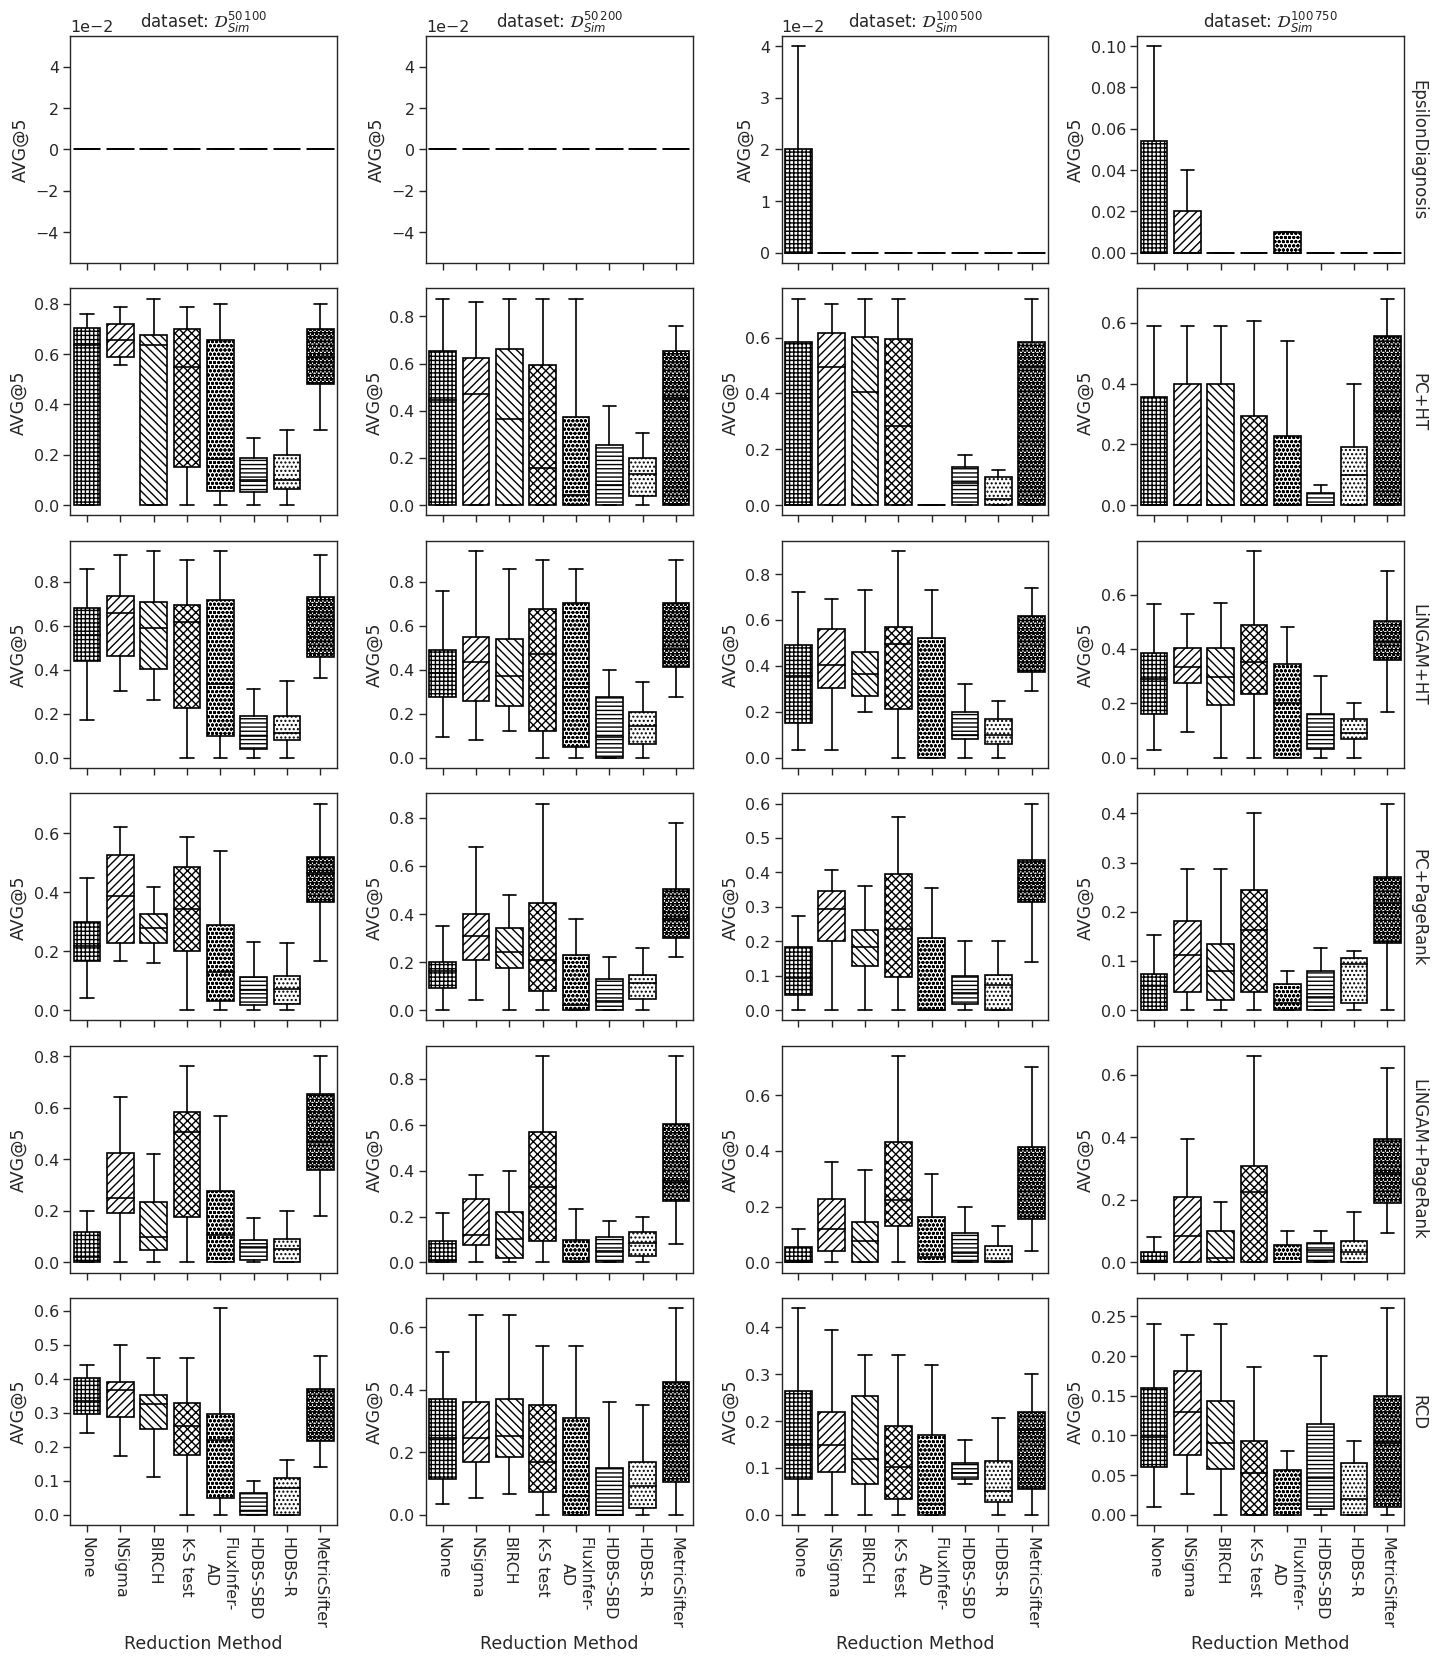

In [123]:
plot_grid(localization_grouped_df.fillna(0).reset_index())


In [ ]:
plot_grid(localization_grouped_df.fillna(0).reset_index().query("noise_type == 'normal'"))


In [104]:
# Investigate why MetricSifter is slow
from simulation.synthetic_data import load_data

normal_data_df, abnormal_data_df, true_root_causes, adjacency_df, anomaly_propagated_nodes = load_data(
    anomaly_type=0,
    data_params=dict(
        num_node=100,
        num_edge=750,
        num_normal_samples=160,
        num_abnormal_samples=20,
    ),
    func_type="identity",
    noise_type="normal",
    weight_generator="normal",
    trial_no=1,
)


In [116]:
from tsdr.multireducer import change_point_clustering_with_kde

concated_data_df = pd.concat([normal_data_df, abnormal_data_df], axis=0, ignore_index=True)
cinfo, remove_metrics = change_point_clustering_with_kde(
    concated_data_df,
    search_method="bottomup",
    cost_model="l2",
    penalty="bic",
    n_bkps=1,
    kde_bandwidth=1.0,
    kde_bandwidth_adjust=1.0,
    multi_change_points=True,
    representative_method=False,
    segment_selection_method="weighted_max",
    n_jobs=-1,
)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

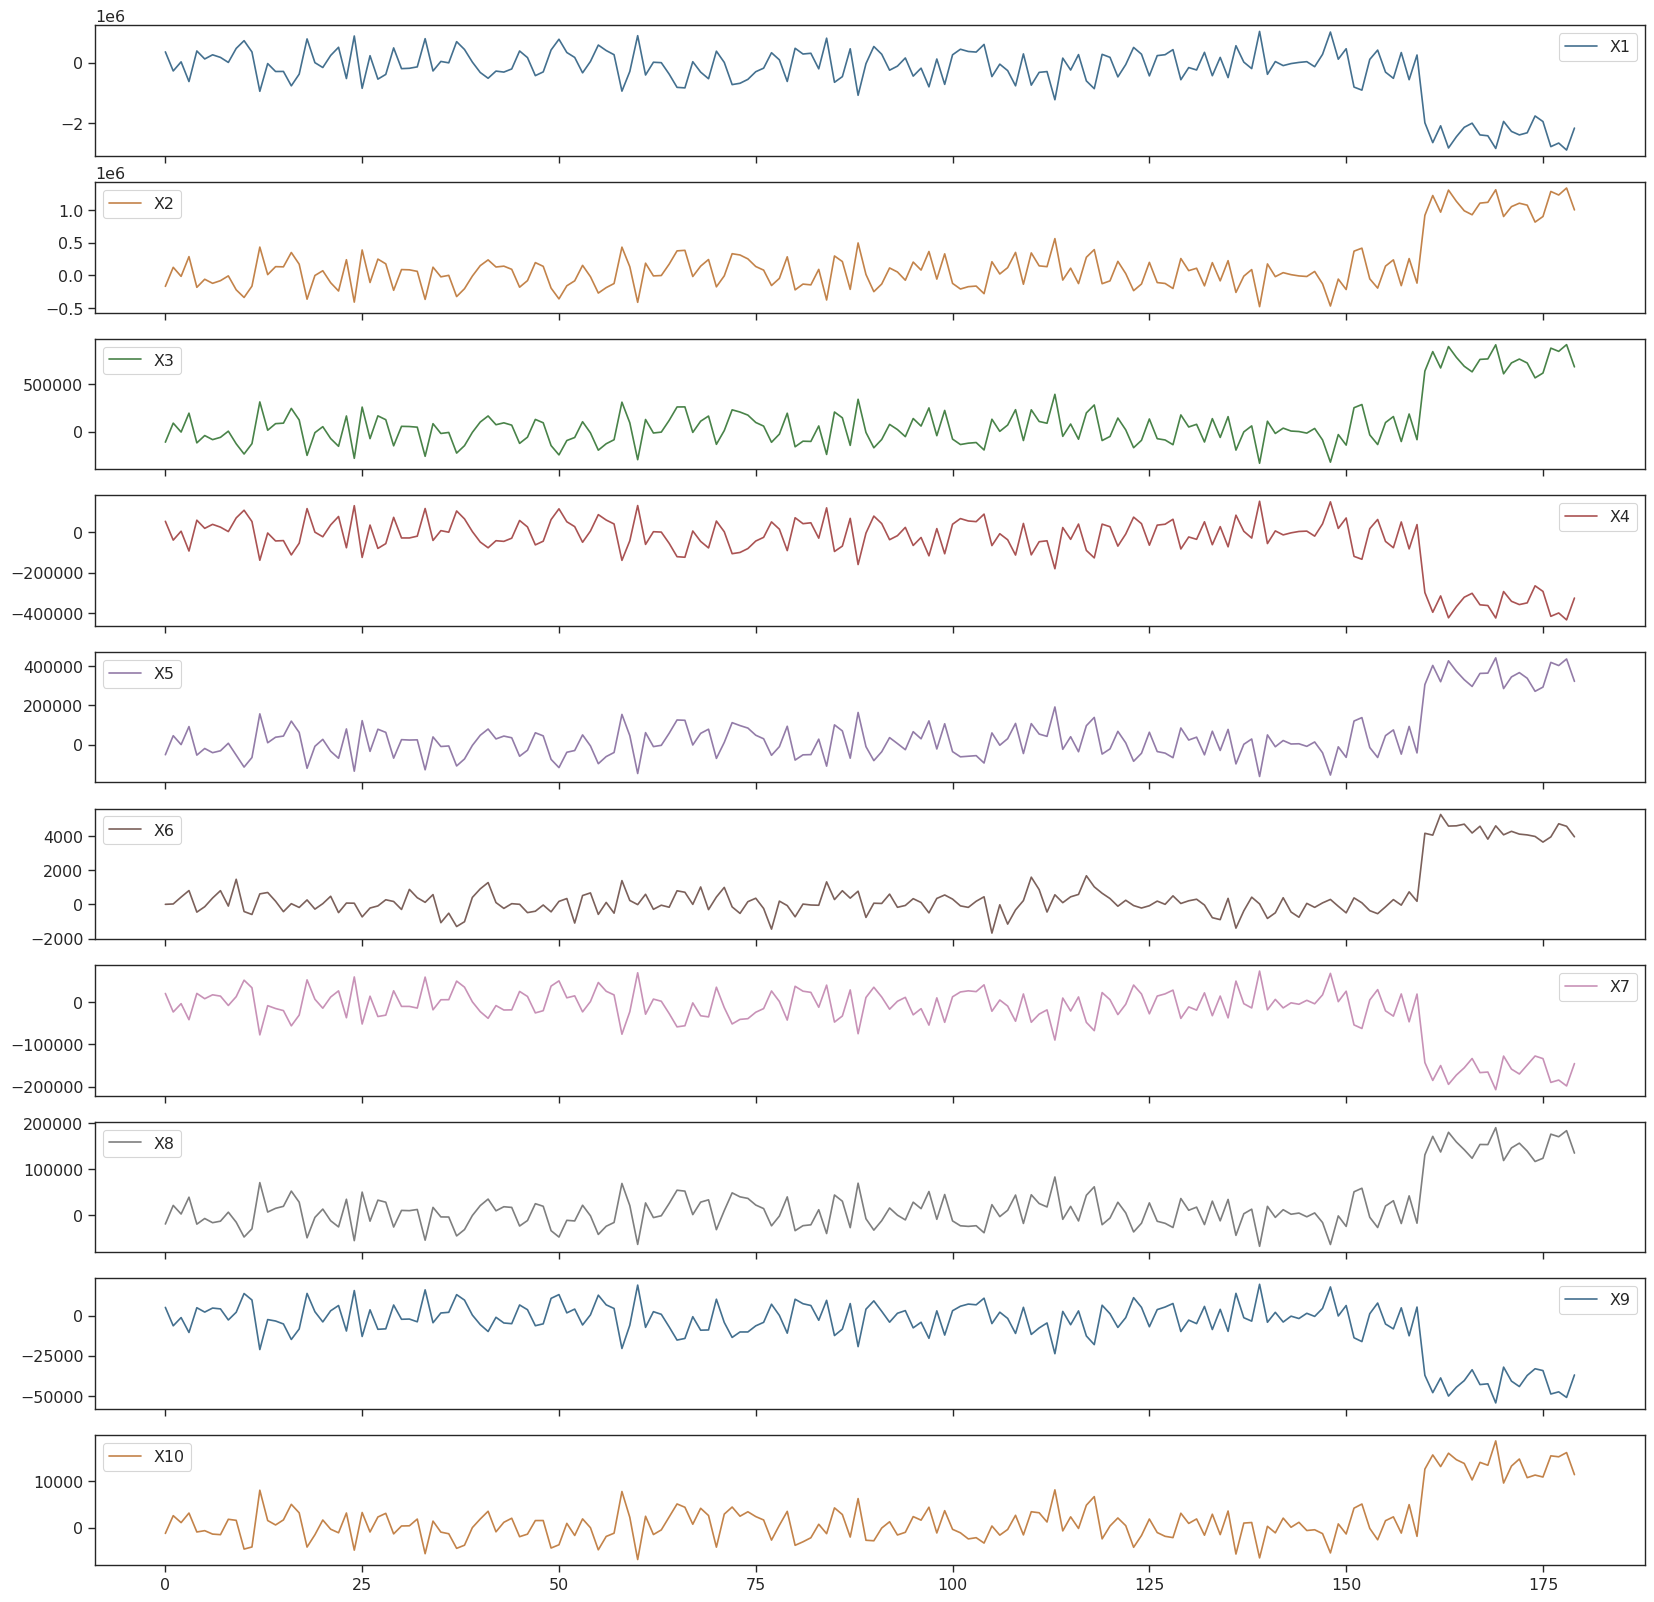

In [109]:
concated_data_df.iloc[:, 0:10].plot(subplots=True, figsize=(20, 20))
